In [190]:
import pyod
import numpy as np
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data_clusters
from pyod.models.knn import KNN
from sklearn.metrics import balanced_accuracy_score

np.random.seed(100)

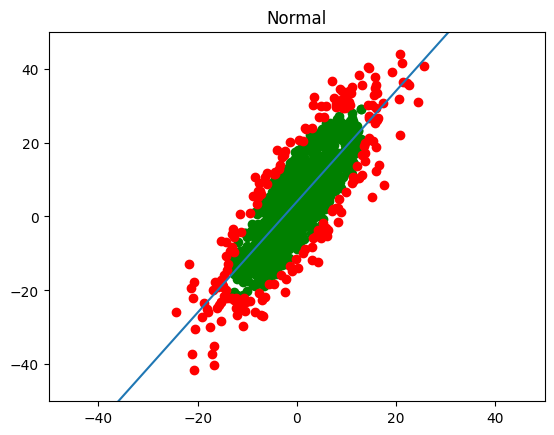

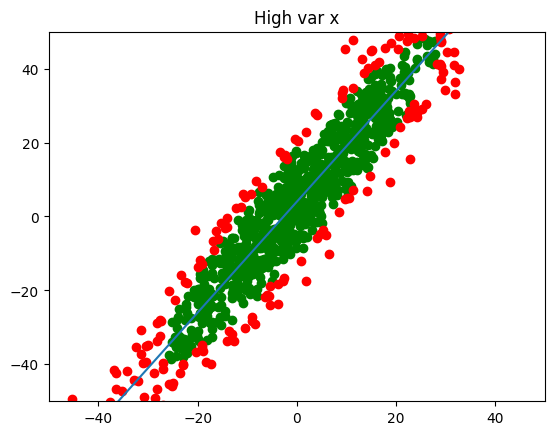

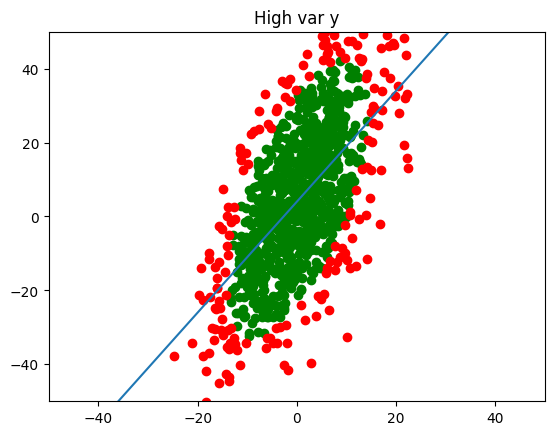

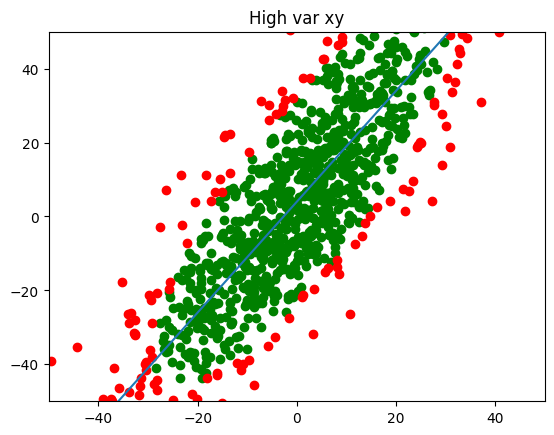

In [88]:
# Exercise 1
# 2D version

a = 1.5 
b = 4 

def random_points(x_stdev, noise_stdev, N=1000):
    x_positions = np.random.normal(loc=0, scale=x_stdev, size=N)
    noise = np.random.normal(0, noise_stdev, size=N)
    y_positions = a * x_positions + b + noise

    X = np.stack((x_positions, y_positions, np.ones(N)), axis=-1) 
    return X

def compute_leverages(X):
   z = np.matmul(X.T, X)
   w = np.linalg.solve(z, X.T)
   H = np.matmul(X, w)
   leverages = [H[i, i] for i in range(len(X))]
   return leverages

# def compute_leverages(X):
#    z = np.matmul(X.T, X)
#    z = np.linalg.inv(z)
#    H = np.matmul(X, np.matmul(z, X.T))
#    leverages = [H[i, i] for i in range(len(X))]
#    return leverages

def plot(points, title):
    plt.xlim(-50, 50)
    plt.ylim(-50, 50)
    leverage_scores = compute_leverages(points)
    expected_value = np.float64(2/1000)

    distances = np.abs(leverage_scores - expected_value)
    threshold = np.quantile(distances, 0.8)

    is_anomaly = distances > threshold
    anomalous = points[is_anomaly]
    non_anomalous = points[~is_anomaly]

    plt.title(title)
    plt.axline((-10, -10 *a +b), (10, 10 * a + b))
    plt.scatter(non_anomalous[:, 0], non_anomalous[:, 1], color="g")
    plt.scatter(anomalous[:, 0], anomalous[:, 1], color="r")
    plt.show()

normal_points = random_points(x_stdev=8, noise_stdev=8) 
high_var_x= random_points(x_stdev=16, noise_stdev=8) 
high_var_y= random_points(x_stdev=8, noise_stdev=16) 
high_var_xy= random_points(x_stdev=16, noise_stdev=16) 

plot(normal_points, "Normal")
plot(high_var_x, "High var x")
plot(high_var_y, "High var y")
plot(high_var_xy, "High var xy")

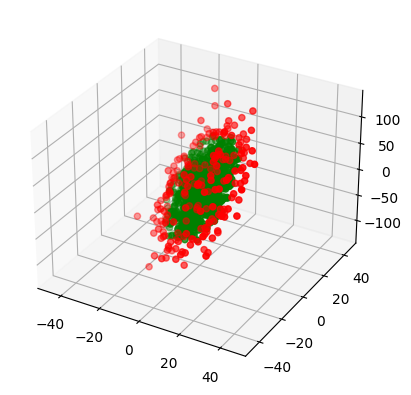

In [99]:
# Exercise 1
# 3D version
a = 1.5 
b =  4 
c = 2

def random_points(x1_stdev, x2_stdev, noise_stdev, N=1000):
    x1_positions = np.random.normal(loc=0, scale=x1_stdev, size=N)
    x2_positions = np.random.normal(loc=0, scale=x2_stdev, size=N)
    noise = np.random.normal(0, noise_stdev, size=N)

    y_positions = a * x1_positions + b*x2_positions + c + noise

    X = np.stack((x1_positions, x2_positions, y_positions, np.ones(N)), axis=-1) 
    return X

def plot(points):
    leverage_scores = compute_leverages(points)
    expected_value = np.float64(2/1000)

    distances = np.abs(leverage_scores - expected_value)
    threshold = np.quantile(distances, 0.8)

    is_anomaly = distances > threshold
    anomalous = points[is_anomaly]
    non_anomalous = points[~is_anomaly]

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)


    ax.scatter(non_anomalous[:, 0], non_anomalous[:, 1], non_anomalous[:, 2], color="g")
    ax.scatter(anomalous[:, 0], anomalous[:, 1], anomalous[:, 2], color="r")
    plt.show()


normal_points = random_points(x1_stdev=8, x2_stdev=8, noise_stdev=16, N=1000) 
plot(normal_points)


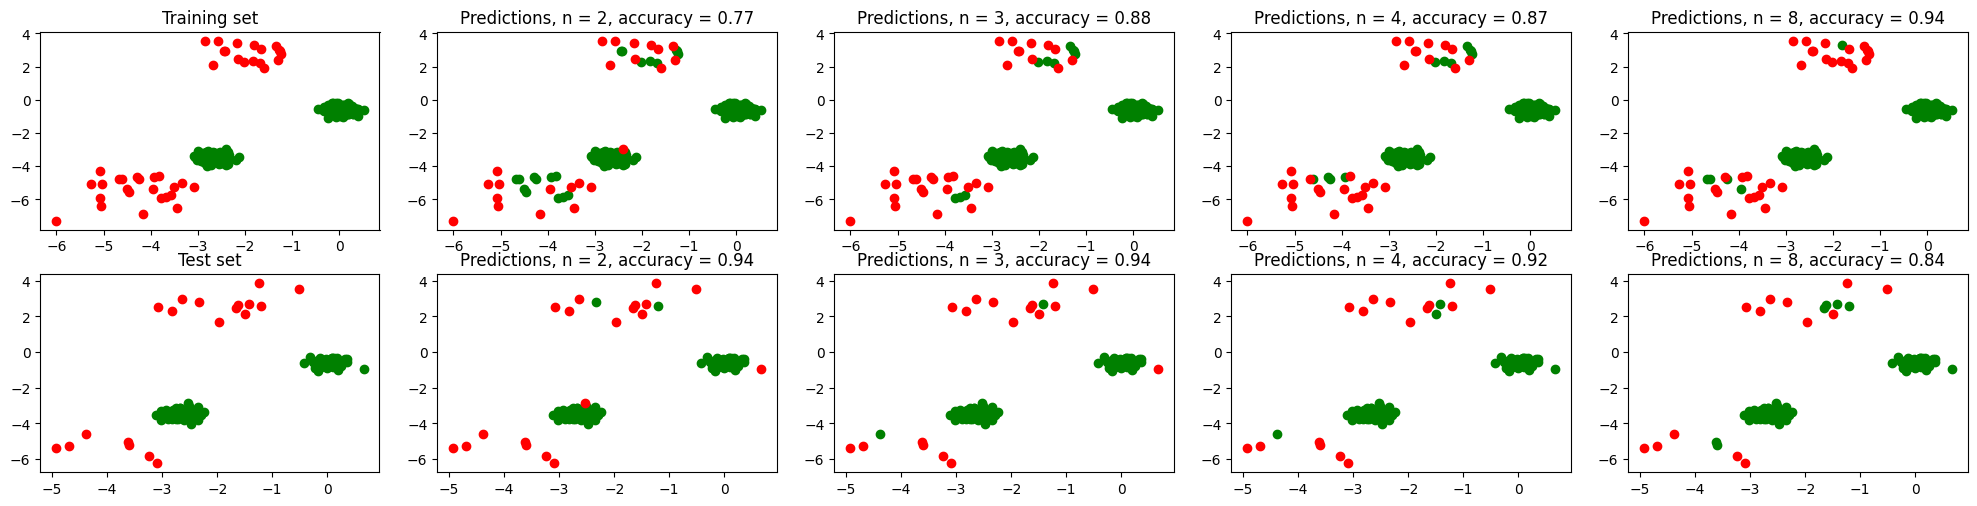

In [201]:
# Exercise 2

plt.rcParams['figure.figsize'] = [20, 5]

# Generating the dataset.
X_train, X_test, y_train, y_test = generate_data_clusters(n_train=400, n_test=200, n_clusters=2, n_features=2, contamination=0.1, random_state=1234)

fig, axs = plt.subplots(2, 5)
fig.tight_layout()

axs[0, 0].set_title("Training set")
axs[0, 0].scatter(X_train[y_train==0][:, 0], X_train[y_train==0][:, 1], c="g")
axs[0, 0].scatter(X_train[y_train==1][:, 0], X_train[y_train==1][:, 1], c="r")

axs[1, 0].set_title("Test set")
axs[1, 0].scatter(X_test[y_test==0][:, 0], X_test[y_test==0][:, 1], c="g")
axs[1, 0].scatter(X_test[y_test==1][:, 0], X_test[y_test==1][:, 1], c="r")

# Fit multiple models.
n_neighbours = [2, 3, 4, 8]
models = [KNN(contamination=0.1, n_neighbors=n) for n in n_neighbours]
for model in models:
    model.fit(X_train)

def try_model(model, X, y, ax):
    predictions = model.predict(X)

    ax.scatter(X[predictions==0][:, 0], X[predictions==0][:, 1], c="g")
    ax.scatter(X[predictions==1][:, 0], X[predictions==1][:, 1], c="r")

    return balanced_accuracy_score(y, predictions)

for i, (n, model) in enumerate(zip(n_neighbours, models)):
    accuracy = try_model(model, X_train, y_train,  axs[0, i+1])
    axs[0, i+1].set_title(f"Predictions, n = {n}, accuracy = {accuracy:.2f}")

for i, (n, model) in enumerate(zip(n_neighbours, models)):
    accuracy = try_model(model, X_test, y_test, axs[1, i+1])
    axs[1, i+1].set_title(f"Predictions, n = {n}, accuracy = {accuracy:.2f}")
